In [2]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import pandas_datareader.data as web
import time
import tensorflow
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
import logging
import math
import os
from sklearn.preprocessing import MinMaxScaler, scale
from keras.utils import np_utils
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation
from keras import optimizers
from sklearn.metrics import mean_squared_error
from keras.models import load_model
from tqdm import tqdm_notebook
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [3]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_rows', 500)

# 데이터 불러오기 / 데이터 정리

In [4]:
IT_nonfinance = pd.read_excel('./data/dongboo/비재무/IT_비재무_TOTAL_최종.xlsx')
Medicine_nonfinance = pd.read_excel('./data/dongboo/비재무/제약_비재무_TOTAL_최종.xlsx')

In [5]:
IT_finance = pd.read_excel('./data/dongboo/IT_TOTAL_재무사항.xlsx')
Medicine_finance = pd.read_excel('./data/dongboo/제약_TOTAL_재무사항.xlsx')

In [6]:
Medicine_nonfinance.drop(["근속_연","근속_월"],axis = 1, inplace= True)

In [7]:
# krx에서 가져온 자료
IT_stock = pd.read_excel('./data/dongboo/IT_주가_total_krx.xlsx')
Medicine_stock = pd.read_excel('./data/dongboo/제약_주가_total_krx.xlsx')

# IT_stock = pd.read_excel('./data/dongboo/IT_TOTAL_주가.xlsx')
# Medicine_stock = pd.read_excel('./data/dongboo/제약_TOTAL_주가.xlsx')

In [8]:
IT_info = pd.merge(IT_finance,IT_nonfinance, how = 'left', on = ['회사명','거래소코드','회계년도'])
Medicine_info = pd.merge(Medicine_finance, Medicine_nonfinance, how = 'left', on = ['회사명','거래소코드','회계년도'])

In [9]:
IT = pd.merge(IT_info, IT_stock, how = 'left', on = ['회사명','거래소코드','회계년도'])
Medicine = pd.merge(Medicine_info,Medicine_stock, how = 'left', on = ['회사명','거래소코드','회계년도'])

In [10]:
IT.columns

Index(['회사명', '거래소코드', '회계년도', '자산(*)', '자본(*)', '* 수권주식수', '*주당 액면가액', '* 발행한 주식총수(*)', '보통주', '우선주',
       ...
       '합계_기말인원_여(명)', '합계_기말인원(명)', '합계_년간평균급여(천원)', '합계_1인평균년간급여(천원)', '합계_평균근속연수', '최고가', '최저가', '종가', '거래량', '거래대금'], dtype='object', length=399)

In [11]:
#del IT['주식매입선택권.1']

# 회사별로 분리

In [12]:
lg = IT[IT['회사명'] == 'LG이노텍(주)']
sdi = IT[IT['회사명'] == '삼성SDI(주)']
ssem = IT[IT['회사명'] == '삼성전기(주)']
hynix = IT[IT['회사명'] == '에스케이하이닉스(주)']

In [13]:
lg

,회사명,거래소코드,회계년도,자산(*),자본(*),* 수권주식수,*주당 액면가액,* 발행한 주식총수(*),보통주,우선주,지배기업주주지분(*),자본금(*),보통주자본금,우선주자본금,신종자본증권,자본잉여금(*),주식발행초과금,배당건설이자,주식매입선택권,감자차익,보험차익,합병차익,자산수증이익,채무면제이익,자기주식처분이익,전환권대가,신주인수권대가,교환권대가,전환권재매입이익,기타자본잉여금,재평가적립금(2001년 이전),기타자본(*),자기주식,자기주식처분손실,주식할인발행차금,주식매입선택권.1,감자차손,파생상품평가이익,파생상품평가손실,전환권재매입손실,기타,기타포괄손익누계액(*),금융자산평가손익,매도가능금융자산평가손익,관계기업 등 기타포괄손익,환산 관련 외환차이 적립금(환율변동차이),해외사업장순투자위험회피 적립금,확정급여제도의 보험수리적 손익 적립금,확정급여제도의 재측정요소,현금흐름위험회피 적립금,주식기준보상 적립금,재평가잉여금,기타.1,이익잉여금(결손금)(*),* (지배)당기순손익,이익준비금,재무구조개선적립금,기업합리화적립금,기타법정적립금,재평가손익,보험수리적손익,기타이익잉여금,미처분이익잉여금(결손금),*전기이월미처분이익잉여금(결손금),비지배주주지분,* (비지배)당기순손익,*비지배주주지분초과손실액,부채(*),* (정상)영업손익(보고서기재),* (정상)영업손익(계산수치),기타이익(*),이자수익,배당금수익,외환거래이익(*),외환차익,외환환산이익,기타외화거래이익,보험차익.1,퇴직연금운용이익,전기오류수정이익,기타.2,기타손실(*),이자비용,외환거래손실(*),외환차손,외화환산손실,기타외환거래손실,법인세추납액,퇴직연금운용손실,전기오류수정손실,기타.3,법인세비용차감전순이익(손실),법인세비용,종속회사 매수일전 순손익,처분된 종속회사 순손익,계속영업이익(손실),중단영업이익(손실),*중단영업손익 법인세효과,당기순이익(손실),기타포괄손익(*),금융자산평가손익.1,매도가능금융자산평가손익.1,관계기업 등 기타포괄손익.1,환산 관련 외환차이(환율변동차이),해외사업장순투자위험회피,현금흐름위험회피 적립금.1,확정급여제도의 보험수리적손익,확정급여제도의 재측정요소.1,주식기준보상 적립금.1,재평가손익.1,기타.4,기타포괄손익관련 법인세,총포괄손익,*(당기순손익 귀속)지배기업주주지분,*계속영업손익,*중단영업손익,*(당기순손익 귀속)비지배주주지분,*계속영업손익.1,*중단영업손익.1,*(총포괄손익 귀속)지배기업주주지분,*(총포괄손익 귀속)비지배주주지분,*주당계속영업이익,*주당순손익,*희석주당계속영업이익,*희석주당순손익,*(지배기업주주지분)주당계속영업이익,*(지배기업주주지분)주당순손익,*(지배기업주주지분)희석주당계속영업이익,*(지배기업주주지분)희석주당순손익,* 성격별 비용계정(*),제품과 재공품의 변동,기업이 수행한 용역으로서 자본화되어 있는 부분,원재료와 저장품(소모품)의 사용액,상품의 판매,기타원가,종업원 급여비용,감가상각비와 기타상각비 및 손상차손,세금과공과,대손상각비,물류비(운송보관),광고 및 판매촉진비,임차료 및 리스료,경상연구개발비,기타비용,기말자본금(*),기초자본금,유상증자(감자),무상증자(감자),주식매수선택권,전환사채,신주인수권부사채,주식배당,합병분할(영업양수도 등)로 인한 변동,회계정책변경누적효과,오류수정 등,연결범위의 변동,외화환산차이,기타.5,기말신종자본증권(*),기초신종자본증권,신종자본증권의 발행,기타.6,기말자본잉여금(*),기초자본잉여금,유상증자(감자).1,무상증자(감자).1,주식발행초과금.1,주식매수선택권.1,감자차손익,보험차익.2,자기주식처분손익,전환권대가(전환사채),신주인수권대가(신주인수권부사채),교환권대가(교환사채),전환권재매입손익,결손금처리,지분법자본잉여금,합병분할(영업양수도 등)로 인한 변동.1,회계정책변경누적효과.1,오류수정 등.1,연결범위의 변동.1,외화환산차이.1,기타.7,기말기타자본(*),기초기타자본,자기주식.1,자기주식처분손실.1,주식할인발행차금.1,주식매입선택권.2,파생상품평가이익.1,파생상품평가손실.1,출자전환채무,신주청약증거금,감자차손익.1,전환권재매입손익.1,지분법자본조정,합병분할(영업양수도 등)로 인한 변동.2,회계정책변경누적효과.2,오류수정 등.2,연결범위의 변동.2,외화환산차이.2,기타.8,기말기타포괄손익누계액(*),기초기타포괄손익누계액,금융자산평가손익.2,매도가능금융자산 평가손익,관계기업 등 기타포괄손익.2,환산 관련 외환차이 적립금(환율변동차이).1,해외사업장순투자위험회피 적립금.1,확정급여제도의 보험수리적 손익 적립금.1,확정급여제도의 재측정요소.2,현금흐름위험회피 적립금.2,주식기준보상 적립금.2,재평가잉여금.1,합병분할(영업양수도 등)로 인한 변동.3,회계정책변경누적효과.3,오류수정 등.3,연결범위의 변동.3,외화환산차이.3,기타.9,기말이익잉여금(결손금)(*),처분후 이익잉여금(결손금)(*),수정후 이익잉여금(결손금)(*),기초이익잉여금(결손금),회계정책변경누적효과.4,전기오류수정손익,기타.10,(연차배당),(신종자본증권 분배금),주식할인발행차금의 상각,자기주식처분손실의 상각,결손금처리.1,기타이익잉여금처분액,(중간배당),확정급여제도의 재측정요소.3,기타포괄손익,당기순이익(총포괄손익),보험수리적손익.1,재평가손익.2,지분법이익잉여금,합병분할(영업양수도 등)로 인한 변동.4,연결범위의 변동.4,외화환산차이.4,기타.11,기말비지배주주지분(*),처분후 비지배주주지분(*),수정후 비지배주주지분(*),기초 비지배주주지분,회계정책변경누적효과.5,전기오류수정손익.1,기타.12,(종속회사의 배당금),기타.13,(중간배당).1,당기순이익(총포괄손익).1,재평가잉여금.2,금융자산평가손익.3,매도가능금융자산 평가손익.1,관계기업 등 지분법평가손익,환산 관련 외환차이 적립금(환율변동차이).2,해외사업장순투자위험회피 적립금.2,확정급여제도의 보험수리적 손익 적립금.2,확정급여제도의 재측정요소.4,현금흐름위험회피 적립금.3,주식기준보상 적립금.3,기타포괄손익누계액,합병분할로 인한 변동,연결범위의 변동.5,외화환산차이.5,기타.14,합계,영업활동으로 인한 현금흐름(간접법)(*),*(직접법)총현금유입(*),재화의 판매와 용역제공에 따른 현금유입,"수입보험료, 보험금, 연금 및 기타 급부금관련 현금유입",이자수취액,배당금수취액,법인세환급,기타현금유입액,*(직접법)총현금유출(*),종업원과 관련하여 직·간접으로 발생하는 현금유출,"수입보험료, 보험금, 연금 및 기타 급부금관련 현금유출",이자비용유출액,배당금지급액,법인세납부,단기매매목적으로 보유하는 계약에서 발생하는 현금유출,기타현금유출액,당기순손익,법인세비용차감전순손익,현금 유출이 없는 비용 등 가산(*),전기오류수정손익.2,비지배주주지분순손익,보험수리적손실,기타.15,(현금 유입이 없는 수익 등 차감)(*),전기오류수정손익.3,비지배주주지분순손익.1,보험수리적이익,기타.16,영업활동으로 인한 자산부채 변동(운전자본 변동)(*),자산의 감소(증가)(*),부채의 증가(감소)(*),정부보조금 등의 변동,기타 운전자본의 변동,*영업에서 창출된 현금흐름,이자수입,이자지급(-),배당금수입,배당금지급(-),법인세환입,법인세납부(-),중단영업관련 현금흐름,투자활동으로 인한 현금흐름(*),투자활동으로 인한 현금유입액(*),정부보조금 등의 변동.1,종속기업 및 기타사업의 지배력 관련한 현금흐름,합병분할(양수도등)으로 인한 현금유입액,기타투자활동으로 인한 현금유입액,(투자활동으로 인한 현금유출액)(*),정부보조금 등의 변동.2,종속기업 및 기타사업의 지배력 관련한 현금흐름.1,합병분할(양수도등)으로 인한 현금유출액,기타투자활동으로 인한 현금유출액,이자수입.1,이자지급(-).1,배당금수입.1,배당금지급(-).1,법인세환입.1,법인세납부(-).1,중단영업관련 현금흐름.1,재무활동으로 인한 현금흐름(*),재무활동으로 인한 현금유입액(*),기타부채의 증가,유상증자,자본금의 증가,자본잉여금의 증가,종속회사의 증자 등,이익잉여금의 증가,자기주식의 처분,주식매입선택권의 행사,연결자본거래로인한현금유입액,종속기업 소유지분 변동에 따른 현금흐름,비지배주주지분의 증가,정부보조금 등의 변동.3,환율변동으로인한 차이조정,합병분할(양수도등)으로 인한 현금유입액.1,기타재무활동으로 인한 현금유입액,(재무활동으로 인한 현금유출액)(*)

In [14]:
greencross = Medicine[Medicine['회사명'] == '(주)녹십자']
daewoong = Medicine[Medicine['회사명'] == '(주)대웅제약']
yoohan = Medicine[Medicine['회사명'] == '(주)유한양행']
hanmi = Medicine[Medicine['회사명'] == '한미약품(주)']

In [15]:
def classify(stock):
    
    # 회계년도 순으로 정렬 및 인덱스 초기화
    stock.sort_values('회계년도', ascending= True, inplace = True)
    
    stock.reset_index(drop = True, inplace = True)
    
    
    # 새로운 변수 추가
    
    stock['3개월후종가'] = stock['종가'][1:].reset_index(drop=True)
    
    stock['분기수익률'] = (stock['3개월후종가'] - stock['종가']) / stock['종가']
    
    stock['수익률상승하락'] = stock['분기수익률']
    
    for i in range(len(stock)):
        if stock['분기수익률'][i] < 0.005:
            stock['수익률상승하락'][i] = 0
        else:
            stock['수익률상승하락'][i] = 1
        
       
    return stock

In [16]:
classify(lg)
classify(sdi)
classify(ssem)
classify(hynix)

classify(greencross)
classify(daewoong)
classify(yoohan)
classify(hanmi)

,회사명,거래소코드,회계년도,자산(*),자본(*),* 수권주식수,*주당 액면가액,* 발행한 주식총수(*),보통주,우선주,지배기업주주지분(*),자본금(*),보통주자본금,우선주자본금,신종자본증권,자본잉여금(*),주식발행초과금,배당건설이자,주식매입선택권,감자차익,보험차익,합병차익,자산수증이익,채무면제이익,자기주식처분이익,전환권대가,신주인수권대가,교환권대가,전환권재매입이익,기타자본잉여금,재평가적립금(2001년 이전),기타자본(*),자기주식,자기주식처분손실,주식할인발행차금,주식매입선택권.1,감자차손,파생상품평가이익,파생상품평가손실,전환권재매입손실,기타,기타포괄손익누계액(*),금융자산평가손익,매도가능금융자산평가손익,관계기업 등 기타포괄손익,환산 관련 외환차이 적립금(환율변동차이),해외사업장순투자위험회피 적립금,확정급여제도의 보험수리적 손익 적립금,확정급여제도의 재측정요소,현금흐름위험회피 적립금,주식기준보상 적립금,재평가잉여금,기타.1,이익잉여금(결손금)(*),* (지배)당기순손익,이익준비금,재무구조개선적립금,기업합리화적립금,기타법정적립금,재평가손익,보험수리적손익,기타이익잉여금,미처분이익잉여금(결손금),*전기이월미처분이익잉여금(결손금),비지배주주지분,* (비지배)당기순손익,*비지배주주지분초과손실액,부채(*),* (정상)영업손익(보고서기재)(3개월),* (정상)영업손익(계산수치)(3개월),기타이익(*)(3개월),이자수익(3개월),배당금수익(3개월),외환거래이익(*)(3개월),외환차익(3개월),외환환산이익(3개월),기타외화거래이익(3개월),보험차익(3개월),퇴직연금운용이익(3개월),전기오류수정이익(3개월),기타(3개월),기타손실(*)(3개월),이자비용(3개월),외환거래손실(*)(3개월),외환차손(3개월),외화환산손실(3개월),기타외환거래손실(3개월),법인세추납액(3개월),퇴직연금운용손실(3개월),전기오류수정손실(3개월),기타(3개월).1,법인세비용차감전순이익(손실)(3개월),법인세비용(3개월),종속회사 매수일전 순손익(3개월),처분된 종속회사 순손익(3개월),계속영업이익(손실)(3개월),중단영업이익(손실)(3개월),*중단영업손익 법인세효과(3개월),당기순이익(손실)(3개월),기타포괄손익(*)(3개월),금융자산평가손익(3개월),매도가능금융자산평가손익(3개월),관계기업 등 기타포괄손익(3개월),환산 관련 외환차이(환율변동차이)(3개월),해외사업장순투자위험회피(3개월),현금흐름위험회피 적립금(3개월),확정급여제도의 보험수리적손익(3개월),확정급여제도의 재측정요소(3개월),주식기준보상 적립금(3개월),재평가손익(3개월),기타(3개월).2,기타포괄손익관련 법인세(3개월),총포괄손익(3개월),*(당기순손익 귀속)지배기업주주지분(3개월),*계속영업손익(3개월),*중단영업손익(3개월),*(당기순손익 귀속)비지배주주지분(3개월),*계속영업손익(3개월).1,*중단영업손익(3개월).1,*(총포괄손익 귀속)지배기업주주지분(3개월),*(총포괄손익 귀속)비지배주주지분(3개월),*주당계속영업이익(3개월),*주당순손익(3개월),*희석주당계속영업이익(3개월),*희석주당순손익(3개월),*(지배기업주주지분)주당계속영업이익(3개월),*(지배기업주주지분)주당순손익(3개월),*(지배기업주주지분)희석주당계속영업이익(3개월),*(지배기업주주지분)희석주당순손익(3개월),* 성격별 비용계정(*)(3개월),제품과 재공품의 변동(3개월),기업이 수행한 용역으로서 자본화되어 있는 부분(3개월),원재료와 저장품(소모품)의 사용액(3개월),상품의 판매(3개월),기타원가(3개월),종업원 급여비용(3개월),감가상각비와 기타상각비 및 손상차손(3개월),세금과공과(3개월),대손상각비(3개월),물류비(운송보관)(3개월),광고 및 판매촉진비(3개월),임차료 및 리스료(3개월),경상연구개발비(3개월),기타비용(3개월),기말자본금(*),기초자본금,유상증자(감자),무상증자(감자),주식매수선택권,전환사채,신주인수권부사채,주식배당,합병분할(영업양수도 등)로 인한 변동,회계정책변경누적효과,오류수정 등,연결범위의 변동,외화환산차이,기타.2,기말신종자본증권(*),기초신종자본증권,신종자본증권의 발행,기타.3,기말자본잉여금(*),기초자본잉여금,유상증자(감자).1,무상증자(감자).1,주식발행초과금.1,주식매수선택권.1,감자차손익,보험차익.1,자기주식처분손익,전환권대가(전환사채),신주인수권대가(신주인수권부사채),교환권대가(교환사채),전환권재매입손익,결손금처리,지분법자본잉여금,합병분할(영업양수도 등)로 인한 변동.1,회계정책변경누적효과.1,오류수정 등.1,연결범위의 변동.1,외화환산차이.1,기타.4,기말기타자본(*),기초기타자본,자기주식.1,자기주식처분손실.1,주식할인발행차금.1,주식매입선택권.2,파생상품평가이익.1,파생상품평가손실.1,출자전환채무,신주청약증거금,감자차손익.1,전환권재매입손익.1,지분법자본조정,합병분할(영업양수도 등)로 인한 변동.2,회계정책변경누적효과.2,오류수정 등.2,연결범위의 변동.2,외화환산차이.2,기타.5,기말기타포괄손익누계액(*),기초기타포괄손익누계액,금융자산평가손익.1,매도가능금융자산 평가손익,관계기업 등 기타포괄손익.1,환산 관련 외환차이 적립금(환율변동차이).1,해외사업장순투자위험회피 적립금.1,확정급여제도의 보험수리적 손익 적립금.1,확정급여제도의 재측정요소.1,현금흐름위험회피 적립금.1,주식기준보상 적립금.1,재평가잉여금.1,합병분할(영업양수도 등)로 인한 변동.3,회계정책변경누적효과.3,오류수정 등.3,연결범위의 변동.3,외화환산차이.3,기타.6,기말이익잉여금(결손금)(*),처분후 이익잉여금(결손금)(*),수정후 이익잉여금(결손금)(*),기초이익잉여금(결손금),회계정책변경누적효과.4,전기오류수정손익,기타.7,(연차배당),(신종자본증권 분배금),주식할인발행차금의 상각,자기주식처분손실의 상각,결손금처리.1,기타이익잉여금처분액,(중간배당),확정급여제도의 재측정요소.2,기타포괄손익,당기순이익(총포괄손익),보험수리적손익.1,재평가손익.1,지분법이익잉여금,합병분할(영업양수도 등)로 인한 변동.4,연결범위의 변동.4,외화환산차이.4,기타.8,기말비지배주주지분(*),처분후 비지배주주지분(*),수정후 비지배주주지분(*),기초 비지배주주지분,회계정책변경누적효과.5,전기오류수정손익.1,기타.9,(종속회사의 배당금),기타.10,(중간배당).1,당기순이익(총포괄손익).1,재평가잉여금.2,금융자산평가손익.2,매도가능금융자산 평가손익.1,관계기업 등 지분법평가손익,환산 관련 외환차이 적립금(환율변동차이).2,해외사업장순투자위험회피 적립금.2,확정급여제도의 보험수리적 손익 적립금.2,확정급여제도의 재측정요소.3,현금흐름위험회피 적립금.2,주식기준보상 적립금.2,기타포괄손익누계액,합병분할로 인한 변동,연결범위의 변동.5,외화환산차이.5,기타.11,합계,영업활동으로 인한 현금흐름(간접법)(*),*(직접법)총현금유입(*),재화의 판매와 용역제공에 따른 현금유입,"수입보험료, 보험금, 연금 및 기타 급부금관련 현금유입",이자수취액,배당금수취액,법인세환급,기타현금유입액,*(직접법)총현금유출(*),종업원과 관련하여 직·간접으로 발생하는 현금유출,"수입보험료, 보험금, 연금 및 기타 급부금관련 현금유출",이자비용유출액,배당금지급액,법인세납부,단기매매목적으로 보유하는 계약에서 발생하는 현금유출,기타현금유출액,당기순손익,법인세비용차감전순손익,현금 유출이 없는 비용 등 가산(*),전기오류수정손익.2,비지배주주지분순손익,보험수리적손실,기타.12,(현금 유입이 없는 수익 등 차감)(*),전기오류수정손익.3,비지배주주지분순손익.1,보험수리적이익,기타.13,영업활동으로 인한 자산부채 변동(운전자본 변동)(*),자산의 감소(증가)(*),부채의 증가(감소)(*),정부보조금 등의 변동,기타 운전자본의 변동,*영업에서 창출된 현금흐름,이자수입,이자지급(-),배당금수입,배당금지급(-),법인세환입,법인세납부(-),중단영업관련 현금흐름,투자활동으로 인한 현금흐름(*),투자활동으로 인한 현금유입액(*),정부보조금 등의 변동.1,종속기업 및 기타사업의 지배력 관련한 현금흐름,합병분할(양수도등)으로 인한 현금유입액,기타투자활동으로 인한 현금유입액,(투자활동으로 인한 현금유출액)(*),정부보조금 등의 변동.2,종속기업 및 기타사업의 지배력 관련한 현금흐름.1,

In [17]:
lg = lg.iloc[:-1,:]
sdi = sdi.iloc[:-1,:]
ssem = ssem.iloc[:-1,:]
hynix = hynix.iloc[:-1,:]

greencross = greencross.iloc[:-1,:]
daewoong = daewoong.iloc[:-1,:]
yoohan = yoohan.iloc[:-1,:]
hanmi = hanmi.iloc[:-1,:]

# 산업별 변수 <3개월 후 종가>와의 상관관계 분석

In [18]:
# 밑에 함수로 해보기!!!!

In [19]:
lg_corr = lg.corr(method = 'pearson')
df_lg = pd.DataFrame(lg_corr['3개월후종가']).reset_index().sort_values('3개월후종가', ascending = False)
df_lg.columns = ['지표','3개월후종가']

sdi_corr = sdi.corr(method = 'pearson')
df_sdi = pd.DataFrame(sdi_corr['3개월후종가']).reset_index().sort_values('3개월후종가', ascending = False)
df_sdi.columns = ['지표','3개월후종가']

ssem_corr = ssem.corr(method = 'pearson')
df_ssem = pd.DataFrame(ssem_corr['3개월후종가']).reset_index().sort_values('3개월후종가', ascending = False)
df_ssem.columns = ['지표','3개월후종가']

hynix_corr = hynix.corr(method = 'pearson')
df_hynix = pd.DataFrame(hynix_corr['3개월후종가']).reset_index().sort_values('3개월후종가', ascending = False)
df_hynix.columns = ['지표','3개월후종가']

# 산업별 상관관계 데이터프레임

In [20]:
pd.concat([df_lg.reset_index(drop = True), df_sdi.reset_index(drop = True), df_ssem.reset_index(drop = True), df_hynix.reset_index(drop = True)],axis = 1)

,지표,3개월후종가,지표,3개월후종가,지표,3개월후종가,지표,3개월후종가
0,3개월후종가,1.000000,3개월후종가,1.000000,3개월후종가,1.000000,3개월후종가,1.000000
1,최고가,0.767493,최고가,0.820795,최고가,0.827799,종가,0.948256
2,종가,0.747660,자기주식수(주),0.811133,종가,0.818502,최고가,0.947936
3,최저가,0.712841,종가,0.809146,최저가,0.801165,최저가,0.944148
4,거래대금,0.686572,최저가,0.781223,거래대금,0.730220,* (정상)영업손익(계산수치),0.930893
5,거래량,0.598758,회계정책변경누적효과.4,0.593481,해외사업장순투자위험회피 적립금,0.703484,* (정상)영업손익(보고서기재),0.928501
6,기말이익잉여금(결손금)(*),0.539389,정부보조금 등의 변동.1,0.580991,* (정상)영업손익(보고서기재),0.659242,법인세비용차감전순이익(손실),0.918030
7,이익잉여금(결손금)(*),0.539389,미처분이익잉여금(결손금),0.474870,* (정상)영업손익(계산수치),0.655114,*(지배기업주주지분)주당순손익,0.915234
8,확정급여제도의 재측정요소.3,0.533428,매도가능금융자산 평가손익.1,0.461993,거래량,0.593055,*(지배기업주주지분)주당계속영업이익,0.915234
9,*(당기순손익 귀속)지배기업주주지분,0.517290,이자지급(-),0.453903,기초자본잉여금,0.545441,*(당기순손익 귀속)지배기업주주지분,0.914956


In [21]:
list_corr = []
order = 30 # 기업별로 상위 30개 상관관계 변수 추출

for i in range(len(df_lg.index[:order])):
    list_corr.append(df_lg.index[:order][i])
    list_corr.append(df_sdi.index[:order][i])
    list_corr.append(df_ssem.index[:order][i])
    list_corr.append(df_hynix.index[:order][i])

variable = pd.Series(list_corr).value_counts()
variable = pd.DataFrame(variable).reset_index()
variable.columns = ['var_index', 'number']

In [22]:
var = []
for i in range(len(variable)):
    var.append(df_lg[df_lg.index == variable['var_index'][i]]['지표'].values[0])
var = pd.DataFrame(var)
var.columns = ['var']

In [23]:
corr = pd.concat([variable,var], axis = 1)
corr = corr[['var_index','var','number']]
corr.head(30)

,var_index,var,number
0,394,종가,4
1,60,미처분이익잉여금(결손금),4
2,393,최저가,4
3,392,최고가,4
4,67,* (정상)영업손익(계산수치),4
5,397,3개월후종가,4
6,66,* (정상)영업손익(보고서기재),3
7,110,총포괄손익,3
8,396,거래대금,3
9,93,계속영업이익(손실),3


# 3개월후 종가 drop 시킴

In [34]:
corr =  corr.drop(5).reset_index(drop = True)

In [35]:
corr

,var_index,var,number
0,394,종가,4
1,60,미처분이익잉여금(결손금),4
2,393,최저가,4
3,392,최고가,4
4,67,* (정상)영업손익(계산수치),4
5,66,* (정상)영업손익(보고서기재),3
6,110,총포괄손익,3
7,396,거래대금,3
8,93,계속영업이익(손실),3
9,89,법인세비용차감전순이익(손실),3


# 위 자료를 보고 변수 선정

In [36]:
deep_lg = lg[corr['var'][:22]]
deep_sdi = sdi[corr['var'][:22]]
deep_ssem = ssem[corr['var'][:22]]
deep_hynix = hynix[corr['var'][:22]]

deep_lg['수익률상승하락'] = lg['수익률상승하락']
deep_sdi['수익률상승하락'] = sdi['수익률상승하락']
deep_ssem['수익률상승하락'] = ssem['수익률상승하락']
deep_hynix['수익률상승하락'] = hynix['수익률상승하락']

In [37]:
# 표준화

from sklearn.preprocessing import StandardScaler

scaler_lg = StandardScaler()
scale_lg = pd.DataFrame(scaler_lg.fit_transform(deep_lg.iloc[:,:-1]))

scaler_sdi = StandardScaler()
scale_sdi = pd.DataFrame(scaler_sdi.fit_transform(deep_sdi.iloc[:,:-1]))

scaler_ssem = StandardScaler()
scale_ssem = pd.DataFrame(scaler_ssem.fit_transform(deep_ssem.iloc[:,:-1]))

scaler_hynix = StandardScaler()
scale_hynix = pd.DataFrame(scaler_hynix.fit_transform(deep_hynix.iloc[:,:-1]))

# 원래 값으로 변환
# scaler_lg.inverse_transform(scale_lg)

In [38]:
# 주가를 합치려고 만듬(마지막 열을 가져오면 됨)
deep_IT = pd.concat([deep_lg,deep_sdi,deep_ssem,deep_hynix], ignore_index=True)

# 표준화한 변수를 합치려고 만듬
scale_IT = pd.concat([scale_lg,scale_sdi,scale_ssem,scale_hynix], ignore_index=True)

scale_IT

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
0,0.203218,-0.431253,-0.088766,0.440716,0.086506,0.117219,0.623991,0.633011,0.844959,0.577988,0.878315,-0.325976,1.159485,-0.614334,2.945501,0.163307,-0.727987,-0.727987,0.494997,-0.146684,2.135468,-1.282872
1,2.056259,0.296818,2.233115,1.886832,1.025009,1.165526,2.093125,1.878677,0.738136,1.061075,2.249426,1.443321,0.970733,2.788557,-4.409914,1.497919,0.161044,0.161044,0.494997,2.513563,-0.876157,-1.282872
2,1.158468,0.738900,1.283794,1.041910,0.747990,0.606023,0.884958,2.411078,1.539851,0.995086,1.366400,-0.775009,1.690830,3.406693,2.410937,2.376040,0.700861,0.700861,0.494997,2.506434,-0.416760,-1.282872
3,0.862197,-2.341078,1.086019,0.668195,-1.833499,-1.728976,-0.736206,0.310820,-0.842527,-1.557092,-0.822966,-2.722385,-0.996072,3.389534,-0.037659,2.116945,0.480619,0.480619,0.494997,2.502017,-0.585839,-1.282872
4,0.422279,0.434428,0.472916,0.375722,-1.147154,-1.054652,-0.551531,0.473221,-0.556316,-0.925656,-0.566171,-1.479143,-0.552890,-0.305535,-0.039655,-0.587624,0.335272,0.335272,0.494997,-0.148084,-1.067482,-0.572198
5,-0.392916,0.384303,-0.270719,-0.488697,-0.696006,-0.741847,-0.452355,-0.882683,-0.486162,-0.670882,-0.501348,-0.863685,-0.477744,-0.319904,-0.035188,-0.679585,0.274067,0.274067,0.494997,-0.147155,-1.823000,-0.572198
6,-1.581591,0.128138,-1.734256,-1.437609,-1.319735,-1.007500,-0.526163,-0.854168,-1.270868,-1.294826,-1.226416,-0.831815,-1.316773,-0.336542,-0.037198,-1.148344,-0.038733,-0.038733,0.494997,-3.784102,0.410715,-0.572198
7,-1.335597,-0.603596,-1.287284,-1.359616,-1.615512,-2.294374,-2.401617,-0.905230,-2.856991,-2.315352,-2.691990,-0.019650,-3.011397,-0.550757,-0.212313,-2.378557,-0.932238,-0.932238,0.494997,-0.161057,2.004433,-0.572198
8,-0.251065,-0.620758,-0.239075,-0.257969,-0.484390,-0.319186,-0.361867,0.067875,-0.361412,-0.332730,-0.386079,-0.126265,-0.344612,-0.292528,-0.028128,-0.494046,-0.953198,-0.953198,0.494997,-0.138740,-1.019123,-0.572198
9,-0.902861,-0.588698,-1.057865,-0.764921,-0.558274,-0.432598,-0.124243,-0.939020,-0.172177,-0.510462,-0.211227,-1.153721,-0.142251,-0.293784,-0.023565,-0.435249,-0.914054,-0.914054,0.494997,-0.138740,0.077338,-0.572198


In [39]:
scale_IT.corr()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
0,1.000000,0.510372,0.993750,0.995259,0.648414,0.568545,0.512629,0.727642,0.495889,0.483912,0.490866,0.372693,0.468493,0.329382,0.072689,0.554983,0.307627,0.307627,0.210016,0.322390,-0.209250,0.117444
1,0.510372,1.000000,0.506436,0.509078,0.439645,0.350835,0.497917,0.367120,0.518700,0.532994,0.495218,0.505834,0.519460,0.259526,0.088968,0.537493,0.500779,0.500779,0.021597,0.056622,0.087465,0.436030
2,0.993750,0.506436,1.000000,0.978205,0.638789,0.557744,0.502037,0.695918,0.486982,0.475371,0.484442,0.367587,0.462410,0.342446,0.037909,0.570470,0.300661,0.300661,0.210678,0.349550,-0.232622,0.108737
3,0.995259,0.509078,0.978205,1.000000,0.651119,0.573642,0.517485,0.748313,0.499426,0.487338,0.492666,0.374615,0.469780,0.315035,0.102345,0.536574,0.311230,0.311230,0.207552,0.295218,-0.186607,0.124590
4,0.648414,0.439645,0.638789,0.651119,1.000000,0.845863,0.702472,0.470840,0.746909,0.760463,0.702459,0.650885,0.698362,0.183430,0.178737,0.583240,0.203370,0.203370,0.210734,0.161985,-0.039360,0.128793
5,0.568545,0.350835,0.557744,0.573642,0.845863,1.000000,0.728893,0.443719,0.760330,0.787203,0.730125,0.721767,0.752154,0.154758,0.166592,0.495816,0.175808,0.175808,0.165453,0.119424,-0.026541,0.055742
6,0.512629,0.497917,0.502037,0.517485,0.702472,0.728893,1.000000,0.396839,0.870804,0.862984,0.917226,0.695544,0.861526,0.244268,0.139742,0.648251,0.241614,0.241614,0.068850,0.248854,0.036595,0.142152
7,0.727642,0.367120,0.695918,0.748313,0.470840,0.443719,0.396839,1.000000,0.356791,0.341769,0.370594,0.235129,0.341533,0.354637,0.163832,0.342472,0.066161,0.066161,0.224975,0.214918,-0.151284,0.039603
8,0.495889,0.518700,0.486982,0.499426,0.746909,0.760330,0.870804,0.356791,1.000000,0.985181,0.935808,0.783471,0.989359,0.179399,0.169209,0.703916,0.295781,0.295781,0.070847,0.120797,0.063447,0.140099
9,0.483912,0.532994,0.475371,0.487338,0.760463,0.787203,0.862984,0.341769,0.985181,1.000000,0.929948,0.874840,0.977184,0.136722,0.138654,0.683123,0.292704,0.292704,0.058144,0.095105,0.087325,0.154437


In [40]:
# data = list_company3[1].loc[:,['순자산(백만원)', '판매비와 관리비(물류원가 등 포함)(백만원)',
#        '법인세비용차감전순이익(백만원)', '법인세비용(백만원)', '계속영업이익(손실)(백만원)',
#         '당기순이익(백만원)', '기타포괄손익(백만원)', '총포괄손익(백만원)', '배당금(백만원)', '3개월뒤종가(원)']]
# data

In [41]:
# # 표준화

# from sklearn.preprocessing import StandardScaler

# #scaler_lg = StandardScaler()
# #scale_lg = pd.DataFrame(scaler_lg.fit_transform(deep_lg.iloc[:,:-1]))


# # IT 업종 표준화

# scaler_IT = StandardScaler()
# scale_lg = pd.DataFrame(scaler_IT.fit_transform(clean_lg))
# scale_hynix = pd.DataFrame(scaler_IT.fit_transform(clean_hynix))
# scale_ssem = pd.DataFrame(scaler_IT.fit_transform(clean_ssem))
# scale_sdi = pd.DataFrame(scaler_IT.fit_transform(clean_sdi))

In [42]:
# #deep_IT = pd.concat([deep_lg,deep_sdi,deep_ssem,deep_hynix], ignore_index=True)

# # 주가를 합치려고 만듬(마지막 열을 가져오면 됨)
# deep_IT = pd.concat([deep_lg,deep_sdi,deep_ssem,deep_hynix], ignore_index=True)

# # 표준화한 변수를 합치려고 만듬
# scale_IT = pd.concat([scale_lg,scale_sdi,scale_ssem,scale_hynix], ignore_index=True)

In [43]:
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import seaborn as sns
import matplotlib
font_location = "c:/Windows/fonts/malgun.ttf"
font_name = font_manager.FontProperties(fname=font_location).get_name()
matplotlib.rc('font', family=font_name)

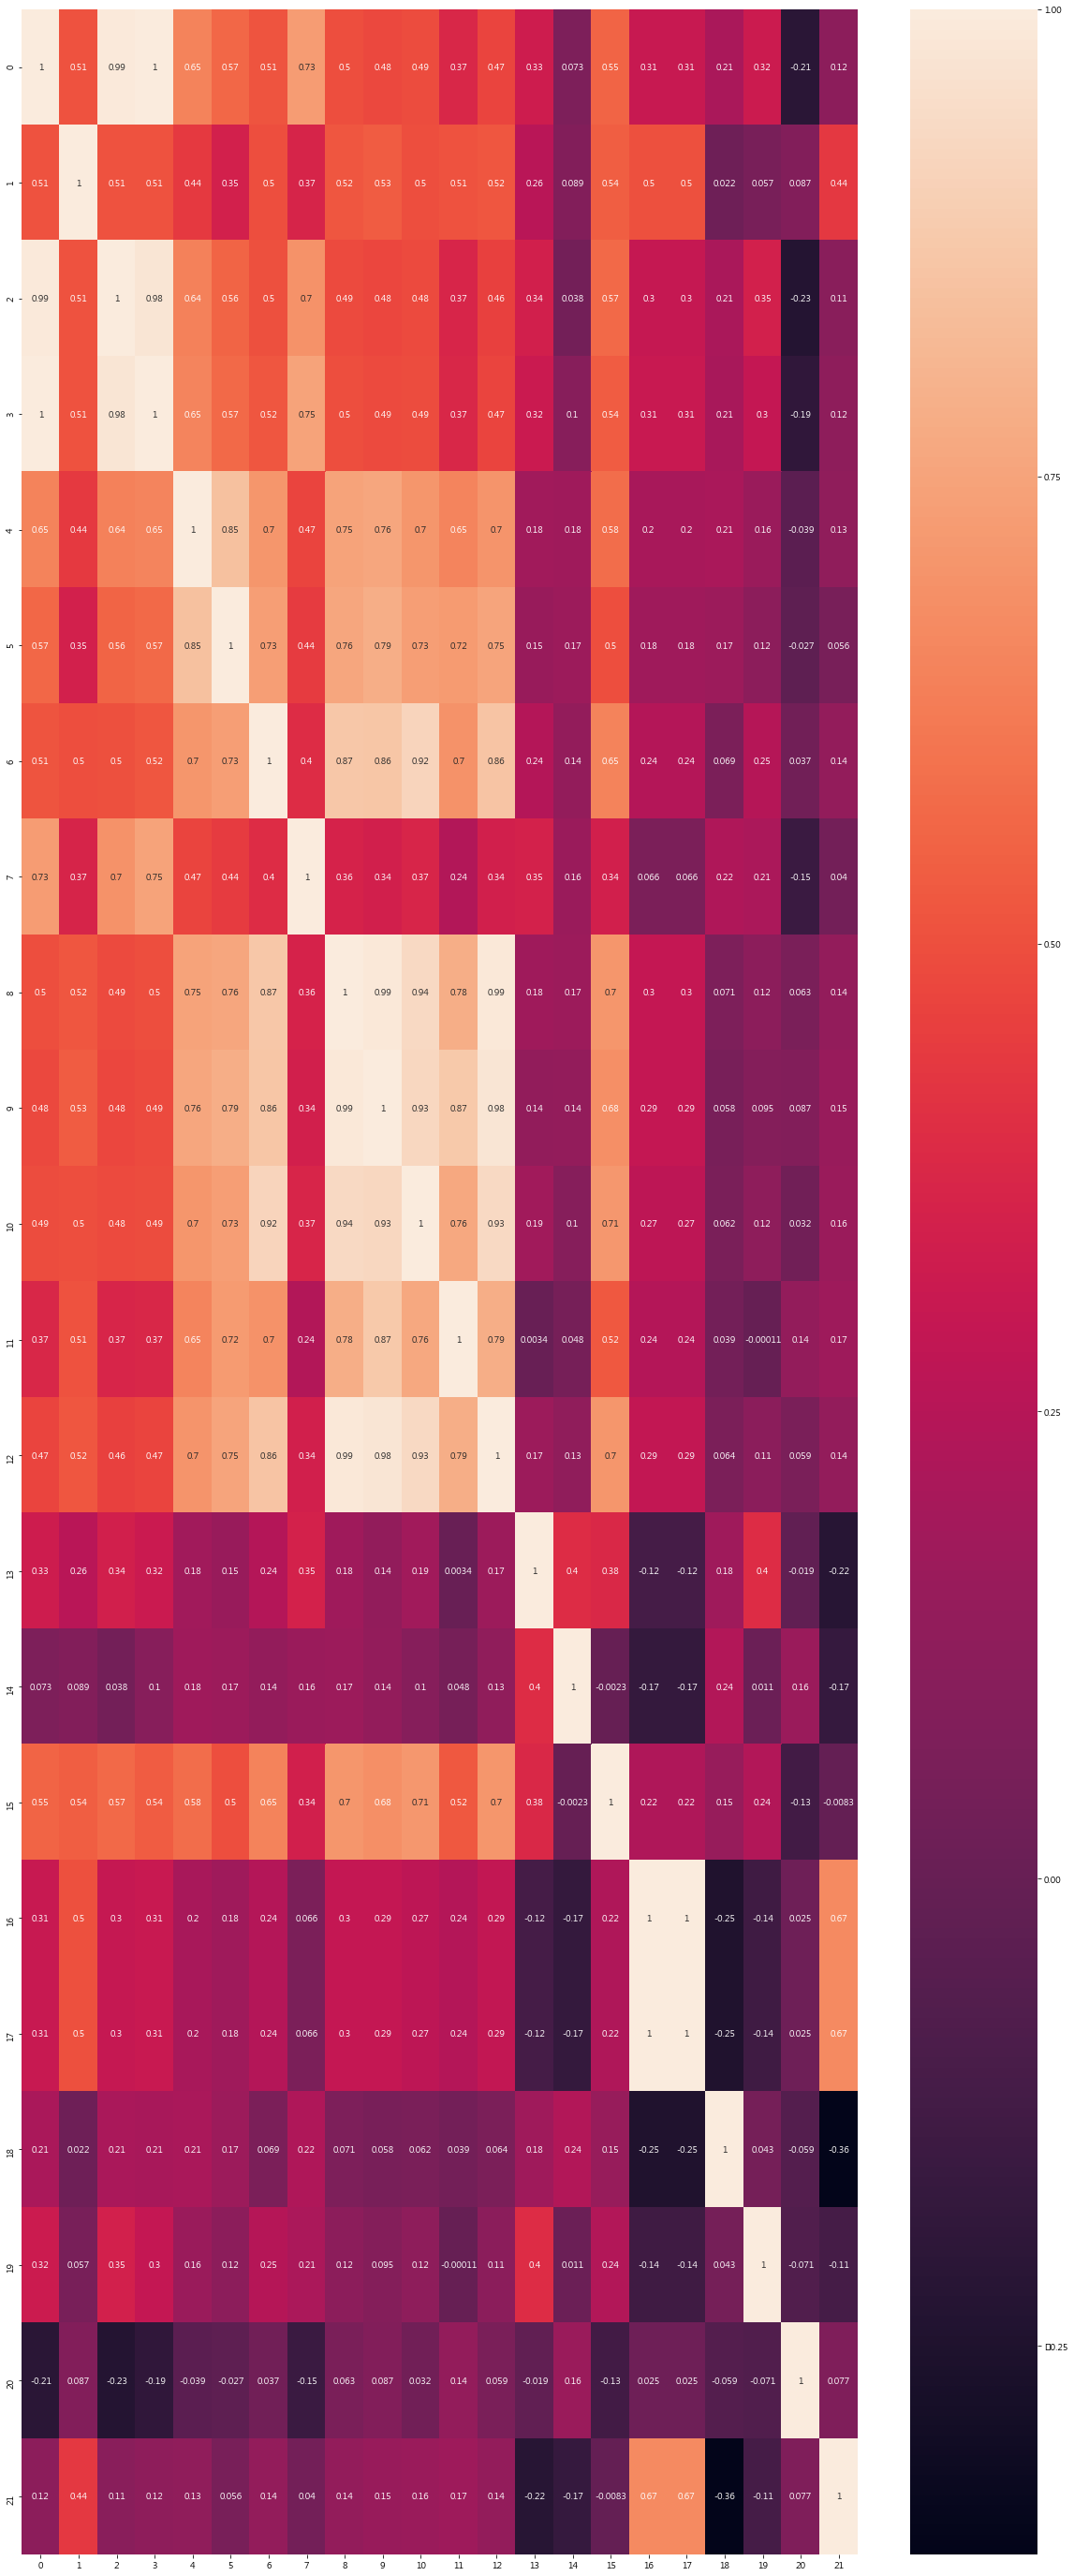

In [44]:
plt.figure(figsize=(20,50))

sns.heatmap(data = scale_IT.corr(), annot = True)
# plt.savefig('tmp.png')

In [45]:
# deep_IT = deep_IT.drop(['발행할 주식의 총수(주)', '현재까지 발행한 주식의 총수(주)', '현재까지 감소한 주식의 총수(주)',
#                         '정규+무기계약_기말인원(남)(명)', '정규+무기계약_기말인원(여)(명)', '기간제_기말인원(남)(명)',
#                         '합계_기말인원_남(명)', '합계_기말인원_여(명)'], axis = 1)
# deep_IT = deep_IT.drop('합계_기말인원(명)', axis = 1)

In [46]:
#scale_IT = scale_IT.drop([2,4],axis = 1)

In [47]:
scale_IT.head() 

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
0,0.203218,-0.431253,-0.088766,0.440716,0.086506,0.117219,0.623991,0.633011,0.844959,0.577988,0.878315,-0.325976,1.159485,-0.614334,2.945501,0.163307,-0.727987,-0.727987,0.494997,-0.146684,2.135468,-1.282872
1,2.056259,0.296818,2.233115,1.886832,1.025009,1.165526,2.093125,1.878677,0.738136,1.061075,2.249426,1.443321,0.970733,2.788557,-4.409914,1.497919,0.161044,0.161044,0.494997,2.513563,-0.876157,-1.282872
2,1.158468,0.738900,1.283794,1.041910,0.747990,0.606023,0.884958,2.411078,1.539851,0.995086,1.366400,-0.775009,1.690830,3.406693,2.410937,2.376040,0.700861,0.700861,0.494997,2.506434,-0.416760,-1.282872
3,0.862197,-2.341078,1.086019,0.668195,-1.833499,-1.728976,-0.736206,0.310820,-0.842527,-1.557092,-0.822966,-2.722385,-0.996072,3.389534,-0.037659,2.116945,0.480619,0.480619,0.494997,2.502017,-0.585839,-1.282872
4,0.422279,0.434428,0.472916,0.375722,-1.147154,-1.054652,-0.551531,0.473221,-0.556316,-0.925656,-0.566171,-1.479143,-0.552890,-0.305535,-0.039655,-0.587624,0.335272,0.335272,0.494997,-0.148084,-1.067482,-0.572198


In [48]:
#deep_IT.columns

In [49]:
scale_IT

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
0,0.203218,-0.431253,-0.088766,0.440716,0.086506,0.117219,0.623991,0.633011,0.844959,0.577988,0.878315,-0.325976,1.159485,-0.614334,2.945501,0.163307,-0.727987,-0.727987,0.494997,-0.146684,2.135468,-1.282872
1,2.056259,0.296818,2.233115,1.886832,1.025009,1.165526,2.093125,1.878677,0.738136,1.061075,2.249426,1.443321,0.970733,2.788557,-4.409914,1.497919,0.161044,0.161044,0.494997,2.513563,-0.876157,-1.282872
2,1.158468,0.738900,1.283794,1.041910,0.747990,0.606023,0.884958,2.411078,1.539851,0.995086,1.366400,-0.775009,1.690830,3.406693,2.410937,2.376040,0.700861,0.700861,0.494997,2.506434,-0.416760,-1.282872
3,0.862197,-2.341078,1.086019,0.668195,-1.833499,-1.728976,-0.736206,0.310820,-0.842527,-1.557092,-0.822966,-2.722385,-0.996072,3.389534,-0.037659,2.116945,0.480619,0.480619,0.494997,2.502017,-0.585839,-1.282872
4,0.422279,0.434428,0.472916,0.375722,-1.147154,-1.054652,-0.551531,0.473221,-0.556316,-0.925656,-0.566171,-1.479143,-0.552890,-0.305535,-0.039655,-0.587624,0.335272,0.335272,0.494997,-0.148084,-1.067482,-0.572198
5,-0.392916,0.384303,-0.270719,-0.488697,-0.696006,-0.741847,-0.452355,-0.882683,-0.486162,-0.670882,-0.501348,-0.863685,-0.477744,-0.319904,-0.035188,-0.679585,0.274067,0.274067,0.494997,-0.147155,-1.823000,-0.572198
6,-1.581591,0.128138,-1.734256,-1.437609,-1.319735,-1.007500,-0.526163,-0.854168,-1.270868,-1.294826,-1.226416,-0.831815,-1.316773,-0.336542,-0.037198,-1.148344,-0.038733,-0.038733,0.494997,-3.784102,0.410715,-0.572198
7,-1.335597,-0.603596,-1.287284,-1.359616,-1.615512,-2.294374,-2.401617,-0.905230,-2.856991,-2.315352,-2.691990,-0.019650,-3.011397,-0.550757,-0.212313,-2.378557,-0.932238,-0.932238,0.494997,-0.161057,2.004433,-0.572198
8,-0.251065,-0.620758,-0.239075,-0.257969,-0.484390,-0.319186,-0.361867,0.067875,-0.361412,-0.332730,-0.386079,-0.126265,-0.344612,-0.292528,-0.028128,-0.494046,-0.953198,-0.953198,0.494997,-0.138740,-1.019123,-0.572198
9,-0.902861,-0.588698,-1.057865,-0.764921,-0.558274,-0.432598,-0.124243,-0.939020,-0.172177,-0.510462,-0.211227,-1.153721,-0.142251,-0.293784,-0.023565,-0.435249,-0.914054,-0.914054,0.494997,-0.138740,0.077338,-0.572198


# 샤비어함수 및 히든레이어 5개

# 및 Validation

In [50]:
# Review : Learning rate and Evaluation
import tensorflow as tf
import random
import matplotlib.pyplot as plt

tf.set_random_seed(777)  # reproducibility
tf.reset_default_graph()


x_data = scale_IT.iloc[:,:-1]
y_data = deep_IT.iloc[:,[-1]]


# parameters
placeholder_num = len(x_data.columns)
learning_rate = 0.0001




X = tf.placeholder(tf.float32, [None, placeholder_num])
Y = tf.placeholder(tf.float32, [None, 1])
keep_prob = tf.placeholder(tf.float32)


W1 = tf.get_variable("W1", shape=[placeholder_num, 32], initializer=tf.contrib.layers.xavier_initializer())
b1 = tf.Variable(tf.random_normal([32]))
L1 = tf.nn.relu(tf.matmul(X, W1) + b1)
L1 = tf.nn.dropout(L1, keep_prob=keep_prob)


W2 = tf.get_variable("W2", shape=[32, 64], initializer=tf.contrib.layers.xavier_initializer())
b2 = tf.Variable(tf.random_normal([64]))
L2 = tf.nn.relu(tf.matmul(L1, W2) + b2)
L2 = tf.nn.dropout(L2, keep_prob=keep_prob)

W3 = tf.get_variable("W3", shape=[64, 64], initializer=tf.contrib.layers.xavier_initializer())
b3 = tf.Variable(tf.random_normal([64]))
L3 = tf.nn.relu(tf.matmul(L2, W3) + b3)
L3 = tf.nn.dropout(L3, keep_prob=keep_prob)


W4 = tf.get_variable("W4", shape=[64, 32], initializer=tf.contrib.layers.xavier_initializer())
b4 = tf.Variable(tf.random_normal([32]))
L4 = tf.nn.relu(tf.matmul(L3, W4) + b4)
L4 = tf.nn.dropout(L4, keep_prob=keep_prob)


W5 = tf.get_variable("W5", shape=[32, 1], initializer=tf.contrib.layers.xavier_initializer())
b5 = tf.Variable(tf.random_normal([1]))
L5 = tf.nn.relu(tf.matmul(L4, W5) + b5)

# hypothesis = tf.matmul(L4, W5) + b5

# define cost/loss & optimizer

# Hypothesis using sigmoid: tf.div(1., 1. + tf.exp(tf.matmul(X, W)))
hypothesis = tf.sigmoid(tf.matmul(L4,W5) + b5)

# cost/loss function
cost = -tf.reduce_mean(Y * tf.log(hypothesis) + (1 - Y) *
                       tf.log(1 - hypothesis))

train = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)
# train = tf.train.AdamOptimizer(1e-4).minimize(cost)

# Accuracy computation
# True if hypothesis>0.5 else False
predicted = tf.cast(hypothesis > 0.5, dtype=tf.float32)
accuracy = tf.reduce_mean(tf.cast(tf.equal(predicted, Y), dtype=tf.float32))

In [57]:
# Launch graph

validation_number = 15
#init_state = lstm_cell.zero_state(128, tf.float32)

with tf.Session() as sess:
    # Initialize TensorFlow variables
    
    sess.run(tf.global_variables_initializer())

    for step in tqdm_notebook(range(12001)):
        cost_val, _ = sess.run([cost, train], feed_dict={X: x_data.iloc[:-validation_number,:], Y: y_data.iloc[:-validation_number,:], keep_prob: 0.8})       
        if step % 200 == 0 or step < 10 :
            print("Step : {} \t Cost : {}".format(step, cost_val))    

    # Accuracy report
    h, c, a = sess.run([hypothesis, predicted, accuracy],
                       feed_dict={X: x_data.iloc[-validation_number:,:], Y: y_data.iloc[-validation_number:,:], keep_prob: 1.0})

Step : 0 	 Cost : 0.8706560730934143
Step : 1 	 Cost : 0.7846724390983582
Step : 2 	 Cost : 0.958425760269165
Step : 3 	 Cost : 0.8875121474266052
Step : 4 	 Cost : 0.9590604305267334
Step : 5 	 Cost : 0.8945134878158569
Step : 6 	 Cost : 0.8498221635818481
Step : 7 	 Cost : 0.9150062799453735
Step : 8 	 Cost : 0.8293214440345764
Step : 9 	 Cost : 0.9502734541893005
Step : 200 	 Cost : 0.9400700330734253
Step : 400 	 Cost : 0.8443355560302734
Step : 600 	 Cost : 0.7963399887084961
Step : 800 	 Cost : 0.8114110231399536
Step : 1000 	 Cost : 0.8417081236839294
Step : 1200 	 Cost : 0.8189740180969238
Step : 1400 	 Cost : 0.865176796913147
Step : 1600 	 Cost : 0.7490020990371704
Step : 1800 	 Cost : 0.7588780522346497
Step : 2000 	 Cost : 0.8190563917160034
Step : 2200 	 Cost : 0.7685349583625793
Step : 2400 	 Cost : 0.7195030450820923
Step : 2600 	 Cost : 0.8311659097671509
Step : 2800 	 Cost : 0.8555580973625183
Step : 3000 	 Cost : 0.8143097758293152
Step : 3200 	 Cost : 0.7874127626419

In [58]:
print('모델 정확도: ', a * 100 , '%')

모델 정확도:  66.66666865348816 %


In [56]:
# pd.DataFrame(y_data.iloc[-validation_number:,:].values, c.ravel()).reset_index()
pd.DataFrame({'real':list(y_data.iloc[-validation_number:,:].values.ravel()),'predict': list(c.ravel())})

,real,predict
0,0.0,0.0
1,1.0,0.0
2,0.0,0.0
3,0.0,0.0
4,0.0,0.0
5,0.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


In [42]:
h # hypothesis

array([[0.38292423],
       [0.38204318],
       [0.3840743 ],
       [0.38272545],
       [0.41285133],
       [0.45627165],
       [0.4093945 ],
       [0.41205576],
       [0.436309  ],
       [0.4111468 ],
       [0.46563333],
       [0.3875237 ],
       [0.40999052],
       [0.4170187 ],
       [0.43653828],
       [0.4264058 ],
       [0.41308004],
       [0.46179205],
       [0.43093994],
       [0.48351872]], dtype=float32)

# 제약

In [43]:
greencross_corr = greencross.corr(method = 'pearson')
df_greencross = pd.DataFrame(lg_corr['3개월후종가']).reset_index().sort_values('3개월후종가', ascending = False)
df_greencross.columns = ['지표','3개월후종가']

daewoong_corr = daewoong.corr(method = 'pearson')
df_daewoong = pd.DataFrame(daewoong_corr['3개월후종가']).reset_index().sort_values('3개월후종가', ascending = False)
df_daewoong.columns = ['지표','3개월후종가']

yoohan_corr = ssem.corr(method = 'pearson')
df_yoohan = pd.DataFrame(yoohan_corr['3개월후종가']).reset_index().sort_values('3개월후종가', ascending = False)
df_yoohan.columns = ['지표','3개월후종가']

hanmi_corr = hanmi.corr(method = 'pearson')
df_hanmi = pd.DataFrame(hanmi_corr['3개월후종가']).reset_index().sort_values('3개월후종가', ascending = False)
df_hanmi.columns = ['지표','3개월후종가']

In [44]:
pd.concat([df_greencross.reset_index(drop = True), df_daewoong.reset_index(drop = True),
           df_yoohan.reset_index(drop = True), df_hanmi.reset_index(drop = True)],axis = 1)

,지표,3개월후종가,지표,3개월후종가,지표,3개월후종가,지표,3개월후종가
0,3개월후종가,1.000000,3개월후종가,1.000000,3개월후종가,1.000000,3개월후종가,1.000000
1,최고가,0.767493,최저가,0.881483,최고가,0.827799,기초자본잉여금,0.895972
2,종가,0.747660,종가,0.875855,종가,0.818502,최고가,0.895014
3,최저가,0.712841,정규+무기계약_기말인원(명),0.867386,최저가,0.801165,종가,0.880045
4,거래대금,0.686572,최고가,0.861320,거래대금,0.730220,최저가,0.858187
5,거래량,0.598758,정규+무기계약_기말인원(여)(명),0.798836,해외사업장순투자위험회피 적립금,0.703484,기초자본금,0.832175
6,기말이익잉여금(결손금)(*),0.539389,기초 현금및현금성자산,0.778524,* (정상)영업손익(보고서기재),0.659242,자산(*),0.812714
7,이익잉여금(결손금)(*),0.539389,기말이익잉여금(결손금)(*),0.749959,* (정상)영업손익(계산수치),0.655114,비지배주주지분,0.810092
8,확정급여제도의 재측정요소.3,0.533428,이익잉여금(결손금)(*),0.749959,거래량,0.593055,기말비지배주주지분(*),0.810092
9,*(당기순손익 귀속)지배기업주주지분,0.517290,지배기업주주지분(*),0.727323,기초자본잉여금,0.545441,부채(*),0.791581


In [45]:
list_corr = []
order = 15 # 기업별로 상위 30개 상관관계 변수 추출

for i in range(len(df_greencross.index[:order])):
    list_corr.append(df_greencross.index[:order][i])
    list_corr.append(df_daewoong.index[:order][i])
    list_corr.append(df_yoohan.index[:order][i])
    list_corr.append(df_hanmi.index[:order][i])

variable = pd.Series(list_corr).value_counts()
variable = pd.DataFrame(variable).reset_index()
variable.columns = ['var_index', 'number']

In [46]:
var = []
for i in range(len(variable)):
    var.append(df_greencross[df_greencross.index == variable['var_index'][i]]['지표'].values[0])
var = pd.DataFrame(var)
var.columns = ['var']

In [47]:
corr = pd.concat([variable,var], axis = 1)
corr = corr[['var_index','var','number']]
corr.head(30)

,var_index,var,number
0,392,최고가,4
1,393,최저가,4
2,394,종가,4
3,397,3개월후종가,4
4,396,거래대금,2
5,218,기말이익잉여금(결손금)(*),2
6,65,부채(*),2
7,51,이익잉여금(결손금)(*),2
8,395,거래량,2
9,161,기초자본잉여금,2


In [65]:
deep_greencross = greencross[corr['var'][4:10]]
deep_yoohan = yoohan[corr['var'][4:10]]
deep_daewoong = daewoong[corr['var'][4:10]]
deep_hanmi = hanmi[corr['var'][4:10]]

deep_greencross['수익률상승하락'] = greencross['수익률상승하락']
deep_yoohan['수익률상승하락'] = yoohan['수익률상승하락']
deep_daewoong['수익률상승하락'] = daewoong['수익률상승하락']
deep_hanmi['수익률상승하락'] = hanmi['수익률상승하락']

In [66]:
# import re

In [67]:
# 표준화

from sklearn.preprocessing import StandardScaler

scaler_greencross = StandardScaler()
scale_greencross = pd.DataFrame(scaler_greencross.fit_transform(deep_greencross.iloc[:,:-1]))

scaler_yoohan = StandardScaler()
scale_yoohan = pd.DataFrame(scaler_yoohan.fit_transform(deep_yoohan.iloc[:,:-1]))

scaler_daewoong = StandardScaler()
scale_daewoong = pd.DataFrame(scaler_daewoong.fit_transform(deep_daewoong.iloc[:,:-1]))

scaler_hanmi = StandardScaler()
scale_hanmi = pd.DataFrame(scaler_hanmi.fit_transform(deep_hanmi.iloc[:,:-1]))

# 원래 값으로 변환
# scaler_lg.inverse_transform(scale_lg)

In [68]:
# 주가를 합치려고 만듬(마지막 열을 가져오면 됨)
deep_Medicine = pd.concat([deep_greencross,deep_yoohan,deep_daewoong,deep_hanmi], ignore_index=True)

# 표준화한 변수를 합치려고 만듬
scale_Medicine = pd.concat([scale_greencross,scale_yoohan,scale_daewoong,scale_hanmi], ignore_index=True)

scale_Medicine

,0,1,2,3,4,5
0,0.187679,-1.484388,-1.193913,-1.484388,0.815247,-2.565887
1,-0.347319,-1.509799,-1.141599,-1.509799,-0.057252,-1.358196
2,0.305857,-1.436356,-1.202584,-1.436356,0.645579,-1.358196
3,-0.253384,-1.172883,-1.056588,-1.172883,-0.287076,-1.358196
4,-0.337316,-1.196336,-1.117250,-1.196336,-0.313360,-1.401482
5,0.006436,-1.191293,-1.261489,-1.191293,0.728525,-0.803862
6,-0.224796,-1.101094,-1.146951,-1.101094,-0.002815,-0.803862
7,-0.271040,-0.842181,-0.849241,-0.842181,-0.234971,-0.803862
8,-0.343178,-0.904210,-0.831978,-0.904210,-0.160755,-0.803862
9,-0.395473,-0.852903,-0.749009,-0.852903,-0.410796,-0.802920


In [69]:
scale_Medicine.corr()

,0,1,2,3,4,5
0,1.000000,0.381145,0.433521,0.381145,0.906258,0.125850
1,0.381145,1.000000,0.934132,1.000000,0.195185,0.235908
2,0.433521,0.934132,1.000000,0.934132,0.216264,0.224567
3,0.381145,1.000000,0.934132,1.000000,0.195185,0.235908
4,0.906258,0.195185,0.216264,0.195185,1.000000,0.056697
5,0.125850,0.235908,0.224567,0.235908,0.056697,1.000000


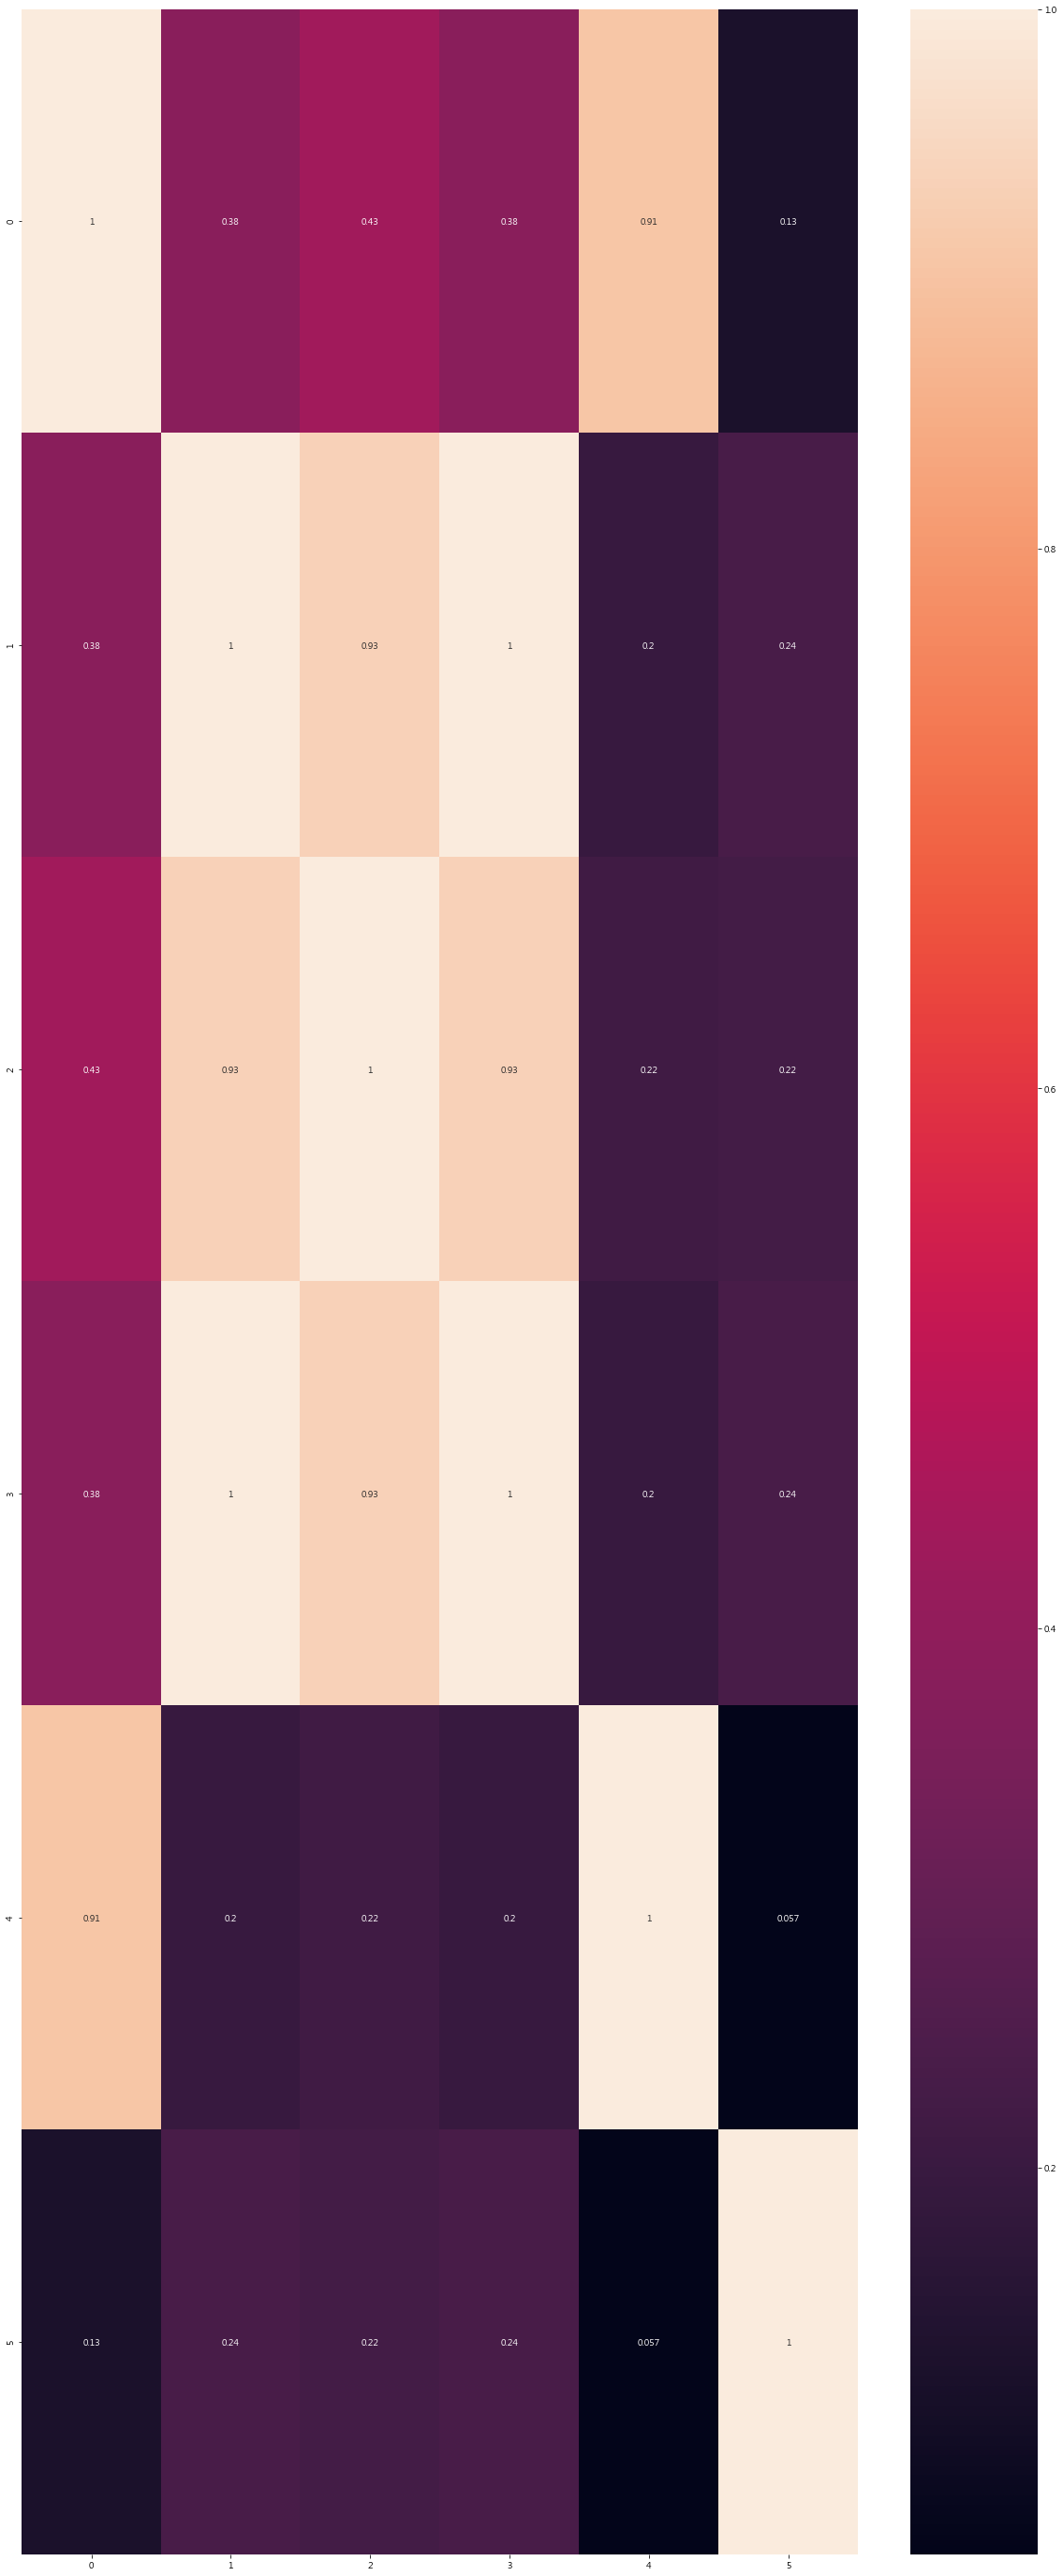

In [70]:
plt.figure(figsize=(20,50))

sns.heatmap(data = scale_Medicine.corr(), annot = True)
# plt.savefig('tmp.png')

In [71]:
scale_Medicine = scale_Medicine.drop([2,4],axis = 1)

In [72]:
# Review : Learning rate and Evaluation
import tensorflow as tf
import random
import matplotlib.pyplot as plt

tf.set_random_seed(777)  # reproducibility
tf.reset_default_graph()


x_data = scale_Medicine.iloc[:,:-1]
y_data = deep_Medicine.iloc[:,[-1]]


# parameters
placeholder_num = len(x_data.columns)
learning_rate = 0.01




X = tf.placeholder(tf.float32, [None, placeholder_num])
Y = tf.placeholder(tf.float32, [None, 1])
keep_prob = tf.placeholder(tf.float32)


W1 = tf.get_variable("W1", shape=[placeholder_num, 32], initializer=tf.contrib.layers.xavier_initializer())
b1 = tf.Variable(tf.random_normal([32]))
L1 = tf.nn.relu(tf.matmul(X, W1) + b1)
L1 = tf.nn.dropout(L1, keep_prob=keep_prob)


W2 = tf.get_variable("W2", shape=[32, 64], initializer=tf.contrib.layers.xavier_initializer())
b2 = tf.Variable(tf.random_normal([64]))
L2 = tf.nn.relu(tf.matmul(L1, W2) + b2)
L2 = tf.nn.dropout(L2, keep_prob=keep_prob)

W3 = tf.get_variable("W3", shape=[64, 64], initializer=tf.contrib.layers.xavier_initializer())
b3 = tf.Variable(tf.random_normal([64]))
L3 = tf.nn.relu(tf.matmul(L2, W3) + b3)
L3 = tf.nn.dropout(L3, keep_prob=keep_prob)


W4 = tf.get_variable("W4", shape=[64, 32], initializer=tf.contrib.layers.xavier_initializer())
b4 = tf.Variable(tf.random_normal([32]))
L4 = tf.nn.relu(tf.matmul(L3, W4) + b4)
L4 = tf.nn.dropout(L4, keep_prob=keep_prob)


W5 = tf.get_variable("W5", shape=[32, 1], initializer=tf.contrib.layers.xavier_initializer())
b5 = tf.Variable(tf.random_normal([1]))
L5 = tf.nn.relu(tf.matmul(L4, W5) + b5)

# hypothesis = tf.matmul(L4, W5) + b5

# define cost/loss & optimizer

# Hypothesis using sigmoid: tf.div(1., 1. + tf.exp(tf.matmul(X, W)))
hypothesis = tf.sigmoid(tf.matmul(L4,W5) + b5)

# cost/loss function
cost = -tf.reduce_mean(Y * tf.log(hypothesis) + (1 - Y) *
                       tf.log(1 - hypothesis))

train = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)
# train = tf.train.AdamOptimizer(1e-4).minimize(cost)

# Accuracy computation
# True if hypothesis>0.5 else False
predicted = tf.cast(hypothesis > 0.5, dtype=tf.float32)
accuracy = tf.reduce_mean(tf.cast(tf.equal(predicted, Y), dtype=tf.float32))

In [73]:
# Launch graph

validation_number = 20
#init_state = lstm_cell.zero_state(128, tf.float32)

with tf.Session() as sess:
    # Initialize TensorFlow variables
    
    sess.run(tf.global_variables_initializer())

    for step in tqdm_notebook(range(5001)):
        cost_val, _ = sess.run([cost, train], feed_dict={X: x_data.iloc[:-validation_number,:], Y: y_data.iloc[:-validation_number,:], keep_prob: 0.8})       
        if step % 200 == 0 or step < 10 :
            print("Step : {} \t Cost : {}".format(step, cost_val))    

    # Accuracy report
    h1, c1, a1 = sess.run([hypothesis, predicted, accuracy],
                       feed_dict={X: x_data.iloc[-validation_number:,:], Y: y_data.iloc[-validation_number:,:], keep_prob: 1.0})

Step : 0 	 Cost : 0.7615057826042175
Step : 1 	 Cost : 0.7546761631965637
Step : 2 	 Cost : 0.6960093975067139
Step : 3 	 Cost : 0.7498283982276917
Step : 4 	 Cost : 0.7887914776802063
Step : 5 	 Cost : 0.8417993187904358
Step : 6 	 Cost : 0.7854007482528687
Step : 7 	 Cost : 0.7572253346443176
Step : 8 	 Cost : 0.7972680926322937
Step : 9 	 Cost : 0.7257819175720215
Step : 200 	 Cost : 0.6612930297851562
Step : 400 	 Cost : 0.6625680923461914
Step : 600 	 Cost : 0.6542438864707947
Step : 800 	 Cost : 0.6564975380897522
Step : 1000 	 Cost : 0.6704654097557068
Step : 1200 	 Cost : 0.6618633270263672
Step : 1400 	 Cost : 0.6369878053665161
Step : 1600 	 Cost : 0.6417966485023499
Step : 1800 	 Cost : 0.6455435156822205
Step : 2000 	 Cost : 0.6546605229377747
Step : 2200 	 Cost : 0.6449605822563171
Step : 2400 	 Cost : 0.6377431154251099
Step : 2600 	 Cost : 0.6442955136299133
Step : 2800 	 Cost : 0.6558389067649841
Step : 3000 	 Cost : 0.6251080632209778
Step : 3200 	 Cost : 0.66330713033

In [74]:
print('모델 정확도: ', a1 * 100 , '%')

모델 정확도:  55.000001192092896 %


In [75]:

# pd.DataFrame(y_data.iloc[-validation_number:,:].values, c.ravel()).reset_index()
pd.DataFrame({'real':list(y_data.iloc[-validation_number:,:].values.ravel()),'predict': list(c1.ravel())})

,real,predict
0,0.0,1.0
1,1.0,1.0
2,0.0,1.0
3,0.0,1.0
4,1.0,1.0
5,1.0,1.0
6,1.0,1.0
7,0.0,0.0
8,1.0,1.0
9,0.0,0.0


In [60]:
h1

array([[0.5871476 ],
       [0.5898687 ],
       [0.5843531 ],
       [0.5839894 ],
       [0.5805045 ],
       [0.59454167],
       [0.52117145],
       [0.55851674],
       [0.6185104 ],
       [0.5671958 ],
       [0.6404834 ],
       [0.6145213 ],
       [0.53907067],
       [0.5406338 ],
       [0.6072899 ],
       [0.5710359 ],
       [0.614305  ],
       [0.61595595],
       [0.5935316 ],
       [0.6131842 ]], dtype=float32)